# Simulation
We simulate the gradient flow in this code

In [2]:
# Let us load the data model
from dataset import NGramDataset
from IPython.display import Math
from typing import Union

# Initialize the dataset
S, L, n_language, alpha, n_sample = 3, 100, 3, 0.3, 1
dataset = NGramDataset(S, L, n_language, alpha, n_sample)
n = n_language - 1

# Get the transition matrix pi
pi = dataset.pi

# Associate each row of pi with a (n-1) vector with elements in {0, 1, ..., S-1} by decoding the index into a base-S number
def ind2code(ind, S, n):
    """Decode the index into a base-S list of length n"""
    assert ind < S**n
    code = [0 for _ in range(n)]
    for j in range(n):
        code[n - j - 1] = ind % S
        ind //= S
    return code
def code2ind(code, S):
    """Encode the base-S list into an index"""
    n = len(code)
    return sum([code[j] * S**(n-j-1) for j in range(n)])
def next_state(parent, son, S, n):
    """Return the next state of the Markov chain given the current state i and the next symbol j
    
    Args:
    parent: Union[int, list], the parent context
    son: int, the next symbol
    S: int, the number of symbols in the alphabet
    n: int, the length of parent context

    Returns:
    state: Union[int, list], the next state of the Markov chain, the form is determined by the input parent
    """
    if isinstance(parent, int):
        return parent // S + son * S**(n-1)
    else:
        return [son] + parent[0:-1]

# Test the functions
for i in range(S**n):
    print(f'pi{ind2code(i, S, n)}: {pi[i]}')

i, j = 5, 2
print(f'The next state (i, j)={(i, j)}:\t', next_state(i, j, S, n))
print(f'The next state (i, j)={(ind2code(i, S, n), j)}:\t', next_state(ind2code(i, S, n), j, S, n))


pi[0, 0]: tensor([0.0333, 0.9283, 0.0385])
pi[0, 1]: tensor([0.2395, 0.4206, 0.3399])
pi[0, 2]: tensor([7.8820e-02, 7.0184e-07, 9.2118e-01])
pi[1, 0]: tensor([9.2811e-01, 7.1707e-02, 1.8202e-04])
pi[1, 1]: tensor([3.7422e-01, 6.2548e-01, 2.9228e-04])
pi[1, 2]: tensor([2.8648e-01, 7.1336e-01, 1.6301e-04])
pi[2, 0]: tensor([0.9484, 0.0382, 0.0134])
pi[2, 1]: tensor([0.1823, 0.8134, 0.0043])
pi[2, 2]: tensor([0.9707, 0.0181, 0.0112])
The next state (i, j)=(5, 2):	 7
The next state (i, j)=([1, 2], 2):	 [2, 1]


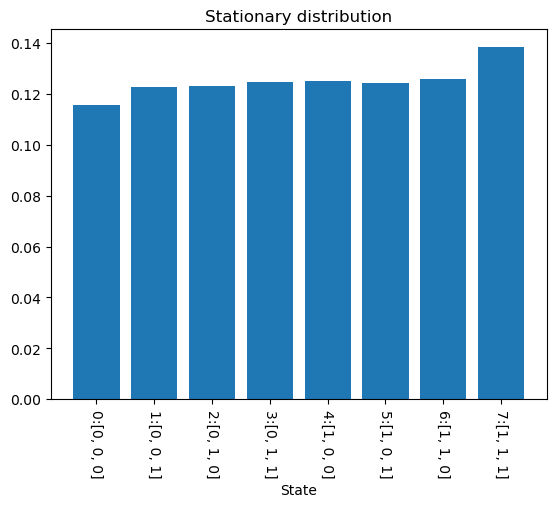

In [14]:
# Let's take a random distribution over the S**n states
import torch
import numpy as np

def get_stationary(pi, S, n, max_iter=100, seed_index=0, output=False):
    """Get the stationary distribution of the Markov chain
    
    Args:
    pi: torch.tensor, the transition matrix
    S: int, the number of symbols in the alphabet
    n: int, the length of the context
    max_iter: int, the maximum number of iterations
    seed_index: int, the index of the seed distribution

    Returns:
    x: torch.tensor, the stationary distribution
    """
    # initialize x
    x = torch.rand(S**n, 1)
    x /= x.sum()

    # get the joint distribution of the parent and the son
    for i in range(max_iter):
        y = x * pi
        # transpose and reshape
        y = y.transpose(0, 1).reshape(-1).reshape(-1, S).sum(axis=-1, keepdims=True)

        # take the TV distance
        d = torch.abs(x - y).sum()
        # print(f'Iteration {i+1}, TV distance: {d}')

        # update x
        x = y
    if output:
        print(f'Final TV distance after {i+1} iterations: {d}')
    return x, d

pi = NGramDataset(S, L, n_language, alpha, n_sample).pi
# Let's test the function
mu, _ = get_stationary(pi, S, n)

# Let's histogram the stationary distribution
import matplotlib.pyplot as plt

def plot_hist(y, S, n, title='Stationary distribution'):
    """Plot the stationary distribution"""
    plt.bar(range(S**n), y.reshape(-1))
    plt.xlabel('State')
    plt.title(title)
    # add the state's code to the x-axis
    plt.xticks(range(S**n), [f'{i}:{ind2code(i, S, n)}' for i in range(S**n)], rotation=-90)
    plt.show()
    
plot_hist(mu, S, n)

In [59]:
# get the stationary distribution for window size 1
def get_stationary_single_symbol(mu, n):
    S = int(np.exp(np.log(len(mu.squeeze())) / n))
    return mu.reshape(S, -1).sum(axis=-1, keepdims=False)
    
def get_stationary_multi_support(mu_prod_pi, support, S, n):
    """Get the stationary distribution for multiple parents
    
    Args:
    mu: torch.tensor, the stationary distribution
    pi: torch.tensor, the transition matrix
    support: Union[list, int], the list of support of the parents or the binary representation of the support
    
    Returns:
    torch.tensor, the stationary distribution"""

    if tuple(mu_prod_pi.shape) == (S**n, S):
        mu_prod_pi = mu_prod_pi.transpose(0, 1).reshape(-1, S)
    mu_extended = mu_prod_pi.view(tuple(
            [S for _ in range(n+1)]
        ))
    
    if isinstance(support, int):
        support = ind2code(support, 2, n)
    assert isinstance(support, list)
    # include the current state
    support_extended = torch.tensor([1] + support, dtype=torch.bool)
    
    # marginalize out the unsupported parents
    # check if all the parents are supported
    if all(support_extended):
        return mu_extended
    else:
        return torch.sum(mu_extended, dim=tuple([i for i in range(n+1) if not support_extended[i]]), keepdim=True)
        
# # calculate the chi-square mutual information
# def chi_square_mutual_info(parent, pi, mu):
#     S = pi.shape[1]
#     # n = log(S, pi.shape[0])
#     n = int(np.log(pi.shape[0]) / np.log(S))

#     # get the stationary distribution for one symbol
#     mu_single = get_stationary_single_symbol(mu, n)
    
#     if parent == -1:
#         # the average chi-square mutual information
#         return mu.reshape(1, -1) @ ((pi ** 2 / mu_single.reshape(1, -1)).sum(axis=-1, keepdims=True) - 1)
#     elif parent == -2:
#         # the inner product of the squared stationary distribution and the mutual information
#         return mu.reshape(1, -1)**2 @ ((pi ** 2 / mu_single.reshape(1, -1)).sum(axis=-1, keepdims=True) - 1)
#     else: 
#         if isinstance(parent, list):
#             parent = code2ind(parent, S)
#         p = pi[parent]
#         # the chi-square mutual information between mu_single and p
#         return (p ** 2 / mu_single).sum() - 1
#     # take the average over all the parents
    
def chi_square_mutual_info(joint_dist, power=1):
    """Calculate the chi-square mutual information
    
    Args:
    joint_dist: torch.tensor, the joint distribution of the parent and the son
    
    Returns:
    torch.tensor, the chi-square mutual information"""
    marginal_dist = joint_dist.sum(dim=tuple(range(1, joint_dist.ndim)), keepdim=True)
    joint_dist_parent = joint_dist.sum(dim=0, keepdim=True)
    return ((((joint_dist / joint_dist_parent) ** 2 / marginal_dist).sum(dim=0, keepdim=True) - 1) * joint_dist_parent**power).sum()

def chi_square_mutual_info_support(support, mu_prod_pi, power=1):
    mu_extended = get_stationary_multi_support(mu_prod_pi, support, S, n)
    return chi_square_mutual_info(mu_extended, power)

# test get_stationary_multi_parent
power = 2
for support in range(0, 2**n):
    chi = chi_square_mutual_info_support(support, mu.reshape(-1, 1) * pi, power)
    print(f'Power {power} chi-square MI for support {ind2code(support, 2, n)}: {chi}')


Power 2 chi-square MI for support [0, 0]: -1.370910695186467e-06
Power 2 chi-square MI for support [0, 1]: 0.09636703133583069
Power 2 chi-square MI for support [1, 0]: 0.2372908592224121
Power 2 chi-square MI for support [1, 1]: 0.21417930722236633


Let us plot the stationary distribution for (n-1)-parents

Iteration 981/1000: 100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 83.77it/s]


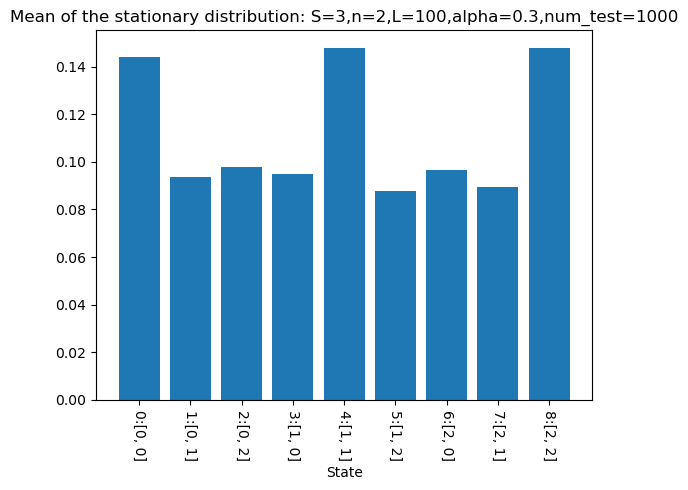

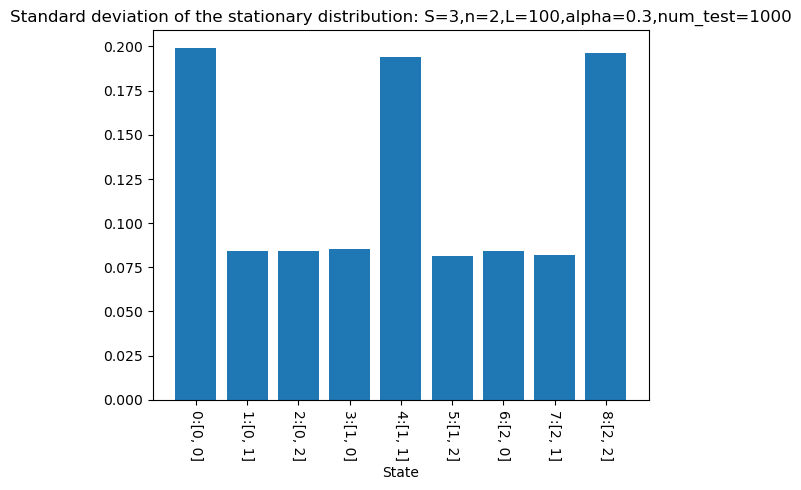

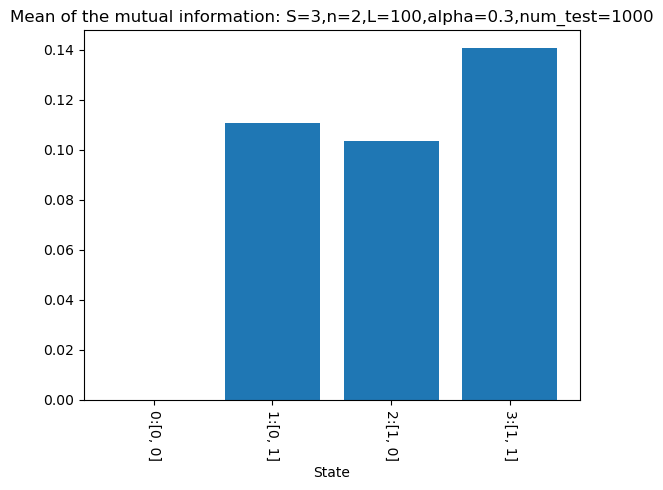

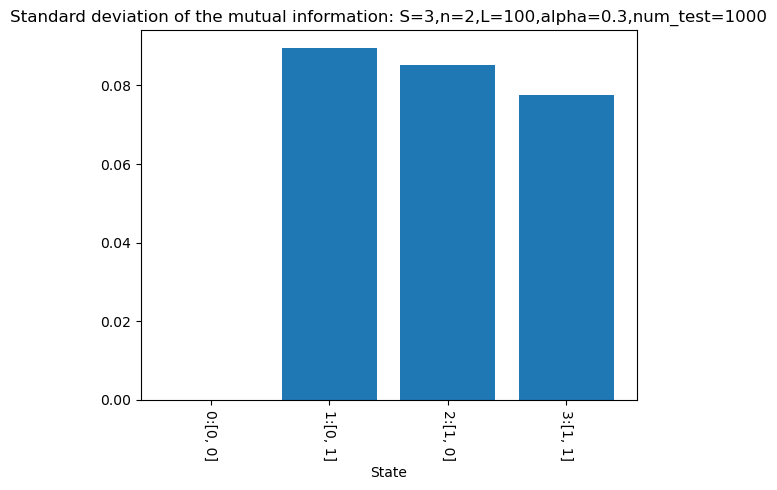

In [61]:
from tqdm import tqdm, trange
# Initialize the dataset
S, L, n_language, alpha, n_sample = 3, 100, 3, 0.3, 1
n = n_language - 1
num_test = 1000
power = 2

pbar = tqdm(range(num_test),ncols=100,mininterval=1)
mu = torch.zeros(num_test, S**n)
MI = torch.zeros(num_test, 2**n)
for j in pbar:
    dataset = NGramDataset(S, L, n_language, alpha, n_sample)
    pi = dataset.pi
    if j % 20 == 0:
        pbar.set_description(f'Iteration {j+1}/{num_test}')
        x, _ = get_stationary(pi, S, n, output=False)
    else: 
        x, _ = get_stationary(pi, S, n)

    mu[j] = x.reshape(-1)

    # test get_stationary_multi_parent
    mu_prod_pi = (x.reshape(-1, 1) * pi).transpose(0, 1).view(
        tuple([S for _ in range(n+1)])
        )
    for i, support in enumerate(range(0, 2**n)):
        MI[j, i] = chi_square_mutual_info_support(support, mu_prod_pi, power)
        # print(f'Power {power} chi-square MI for support {ind2code(support, 2, n)}: {chi}')

    # compute the mutual information
    for ind in range(2**n):
        support = ind2code(ind, 2, n)
        

mean = mu.mean(axis=0)
std = mu.std(axis=0)

# Let's plot the mean and standard deviation of the stationary distribution
plot_hist(mean.numpy(), S, n, title=f'Mean of the stationary distribution: S={S},n={n},L={L},alpha={alpha},num_test={num_test}')
plot_hist(std.numpy(), S, n, title=f'Standard deviation of the stationary distribution: S={S},n={n},L={L},alpha={alpha},num_test={num_test}')

# Let's plot the mutual information
mean_MI = MI.mean(axis=0)
std_MI = MI.std(axis=0)

plot_hist(mean_MI.numpy(), 2, n, title=f'Mean of the mutual information: S={S},n={n},L={L},alpha={alpha},num_test={num_test}')
plot_hist(std_MI.numpy(), 2, n, title=f'Standard deviation of the mutual information: S={S},n={n},L={L},alpha={alpha},num_test={num_test}')



Iteration 981/1000: 100%|███████████████████████████████████████| 1000/1000 [00:11<00:00, 84.55it/s]


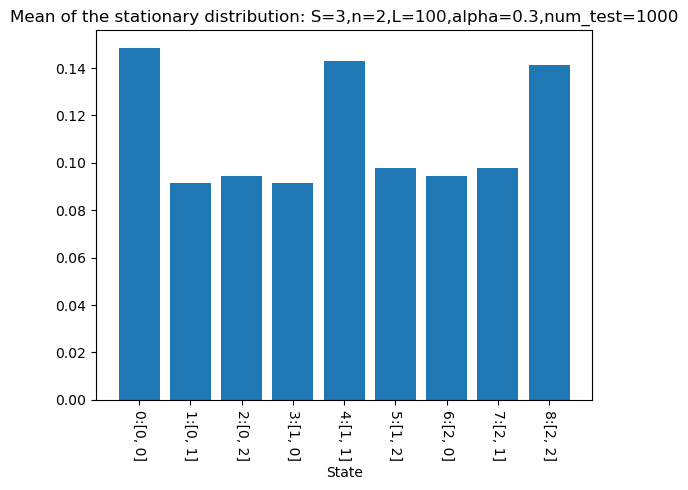

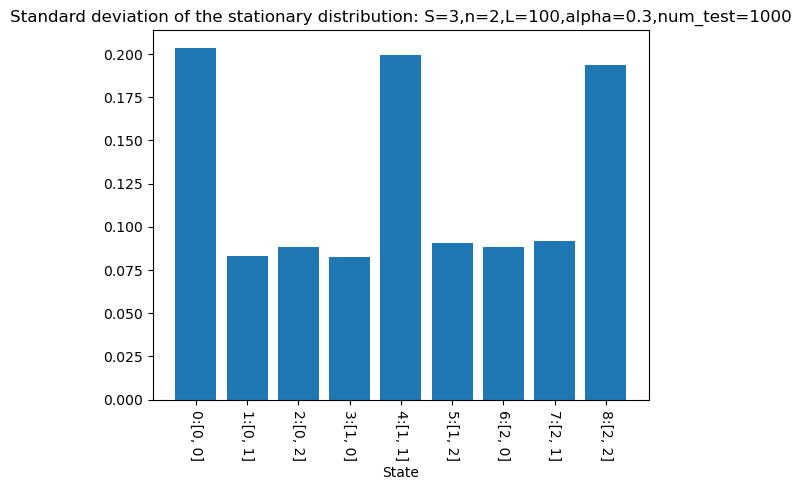

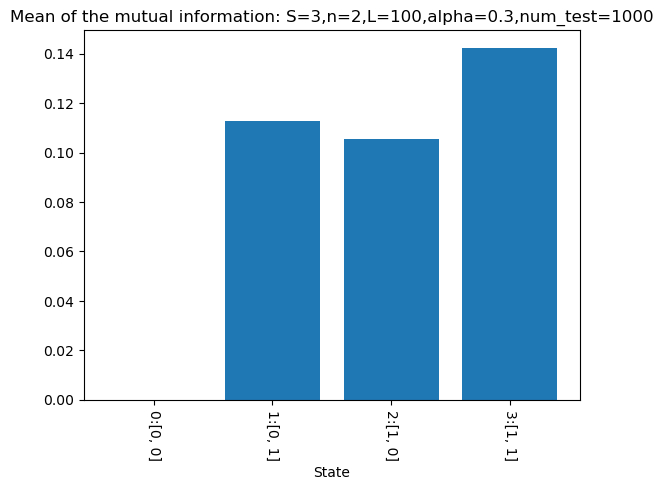

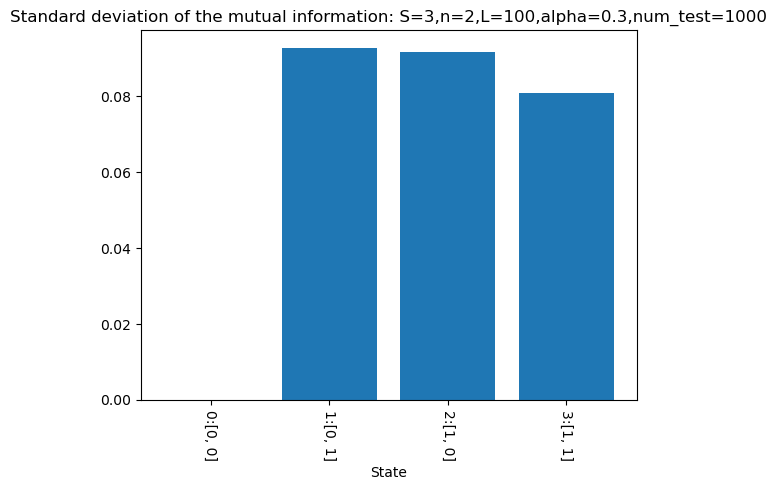

In [62]:
from tqdm import tqdm, trange
# Initialize the dataset
S, L, n_language, alpha, n_sample = 3, 100, 3, 0.3, 1
n = n_language - 1
num_test = 1000
power = 2

pbar = tqdm(range(num_test),ncols=100,mininterval=1)
mu = torch.zeros(num_test, S**n)
MI = torch.zeros(num_test, 2**n)
for j in pbar:
    dataset = NGramDataset(S, L, n_language, alpha, n_sample)
    pi = dataset.pi
    if j % 20 == 0:
        pbar.set_description(f'Iteration {j+1}/{num_test}')
        x, _ = get_stationary(pi, S, n, output=False)
    else: 
        x, _ = get_stationary(pi, S, n)

    mu[j] = x.reshape(-1)

    # test get_stationary_multi_parent
    mu_prod_pi = (x.reshape(-1, 1) * pi).transpose(0, 1).view(
        tuple([S for _ in range(n+1)])
        )
    for i, support in enumerate(range(0, 2**n)):
        MI[j, i] = chi_square_mutual_info_support(support, mu_prod_pi, power)
        # print(f'Power {power} chi-square MI for support {ind2code(support, 2, n)}: {chi}')

    # compute the mutual information
    for ind in range(2**n):
        support = ind2code(ind, 2, n)
        

mean = mu.mean(axis=0)
std = mu.std(axis=0)

# Let's plot the mean and standard deviation of the stationary distribution
plot_hist(mean.numpy(), S, n, title=f'Mean of the stationary distribution: S={S},n={n},L={L},alpha={alpha},num_test={num_test}')
plot_hist(std.numpy(), S, n, title=f'Standard deviation of the stationary distribution: S={S},n={n},L={L},alpha={alpha},num_test={num_test}')

# Let's plot the mutual information
mean_MI = MI.mean(axis=0)
std_MI = MI.std(axis=0)

plot_hist(mean_MI.numpy(), 2, n, title=f'Mean of the mutual information: S={S},n={n},L={L},alpha={alpha},num_test={num_test}')
plot_hist(std_MI.numpy(), 2, n, title=f'Standard deviation of the mutual information: S={S},n={n},L={L},alpha={alpha},num_test={num_test}')



Iteration 4981/5000: 100%|██████████████████████████████████████| 5000/5000 [02:19<00:00, 35.95it/s]


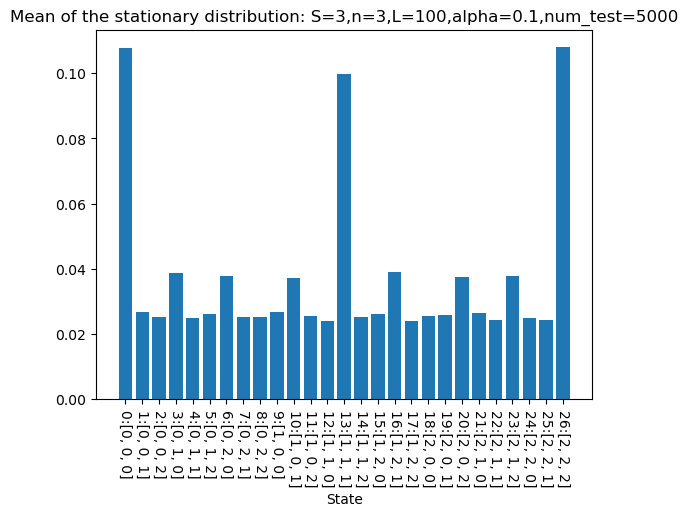

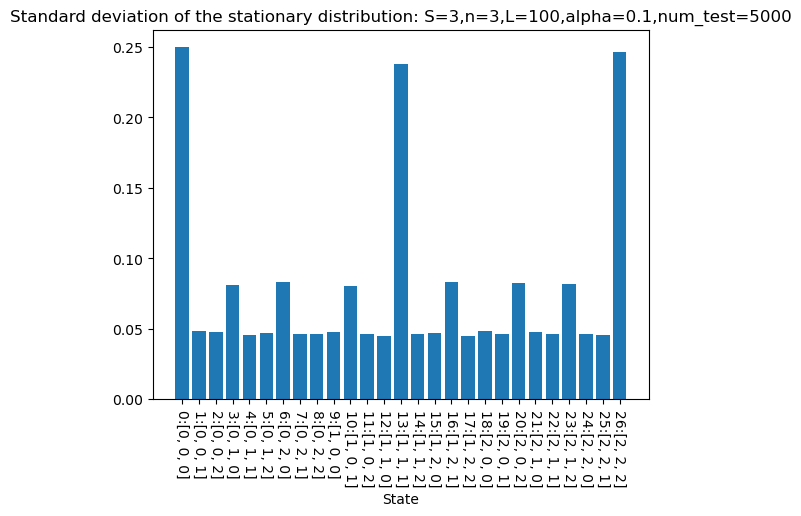

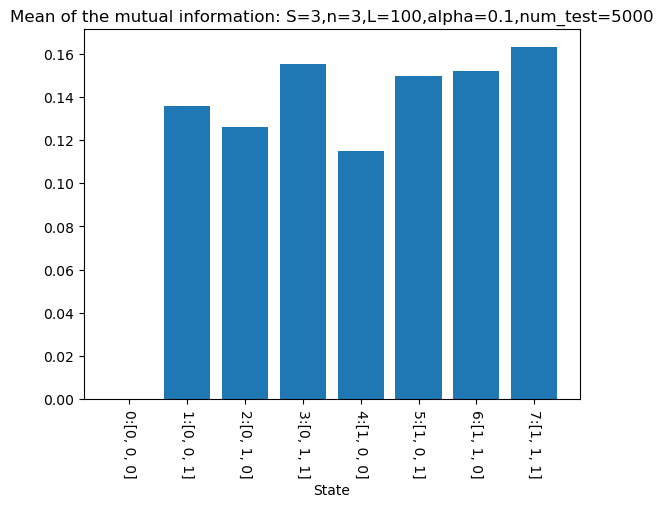

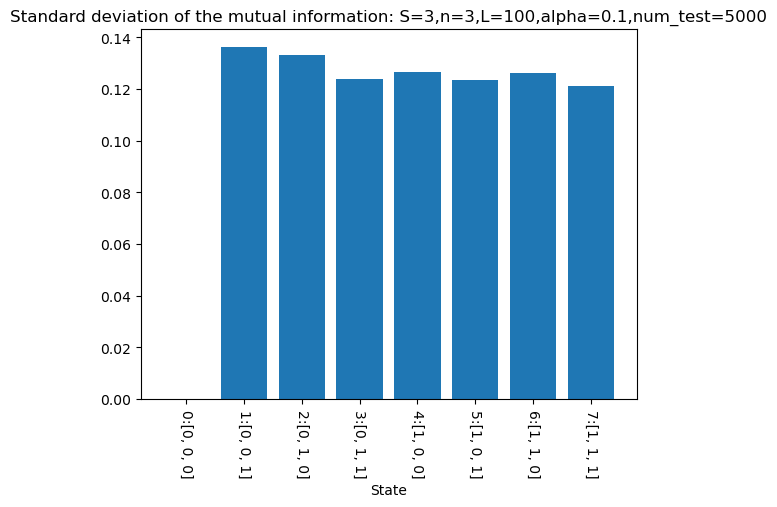

In [34]:
from tqdm import tqdm, trange
# Initialize the dataset
S, L, n_language, alpha, n_sample = 3, 100, 4, 0.1, 1
n = n_language - 1
num_test = 5000
power = 2

pbar = tqdm(range(num_test),ncols=100,mininterval=1)
mu = torch.zeros(num_test, S**n)
MI = torch.zeros(num_test, 2**n)
for j in pbar:
    dataset = NGramDataset(S, L, n_language, alpha, n_sample)
    pi = dataset.pi
    if j % 20 == 0:
        pbar.set_description(f'Iteration {j+1}/{num_test}')
        x, _ = get_stationary(pi, S, n, output=False, max_iter=1000)
    else: 
        x, _ = get_stationary(pi, S, n, max_iter=1000)

    mu[j] = x.reshape(-1)

    # test get_stationary_multi_parent
    mu_prod_pi = (x.reshape(-1, 1) * pi).transpose(0, 1).view(
        tuple([S for _ in range(n+1)])
        )
    for i, support in enumerate(range(0, 2**n)):
        MI[j, i] = chi_square_mutual_info_support(support, mu_prod_pi, power)
        # print(f'Power {power} chi-square MI for support {ind2code(support, 2, n)}: {chi}')

    # compute the mutual information
    for ind in range(2**n):
        support = ind2code(ind, 2, n)
        

mean = mu.mean(axis=0)
std = mu.std(axis=0)

# Let's plot the mean and standard deviation of the stationary distribution
plot_hist(mean.numpy(), S, n, title=f'Mean of the stationary distribution: S={S},n={n},L={L},alpha={alpha},num_test={num_test}')
plot_hist(std.numpy(), S, n, title=f'Standard deviation of the stationary distribution: S={S},n={n},L={L},alpha={alpha},num_test={num_test}')

# Let's plot the mutual information
mean_MI = MI.mean(axis=0)
std_MI = MI.std(axis=0)

plot_hist(mean_MI.numpy(), 2, n, title=f'Mean of the mutual information: S={S},n={n},L={L},alpha={alpha},num_test={num_test}')
plot_hist(std_MI.numpy(), 2, n, title=f'Standard deviation of the mutual information: S={S},n={n},L={L},alpha={alpha},num_test={num_test}')



Iteration 4981/5000: 100%|██████████████████████████████████████| 5000/5000 [02:18<00:00, 36.03it/s]


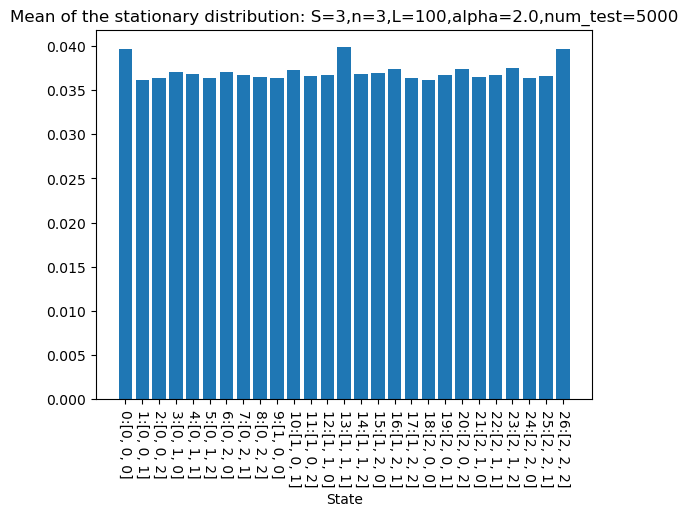

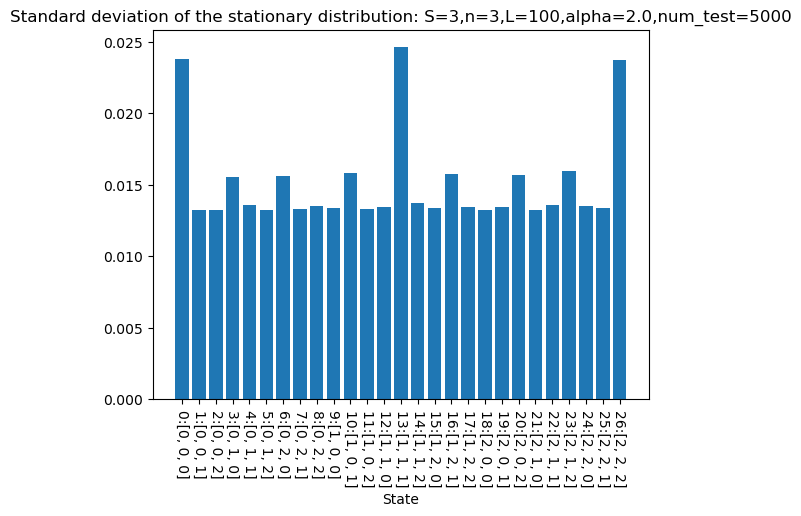

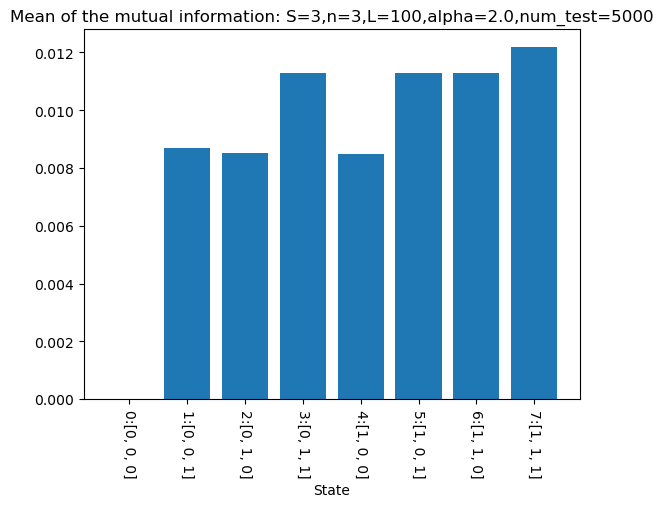

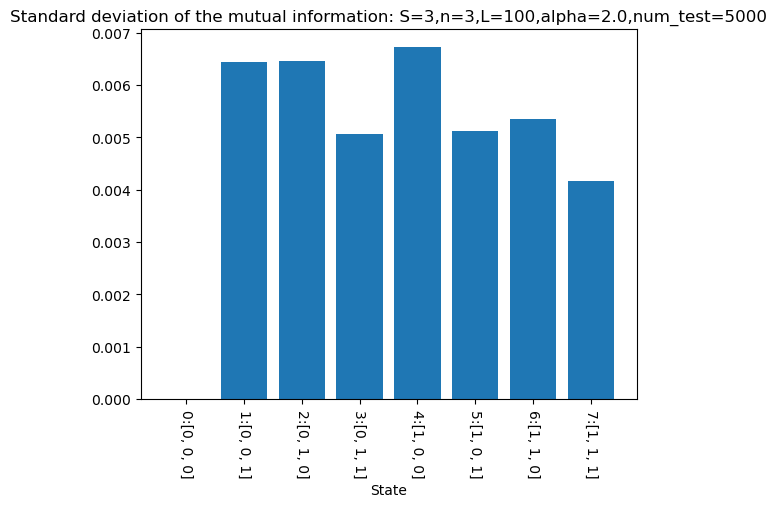

In [36]:
from tqdm import tqdm, trange
# Initialize the dataset
S, L, n_language, alpha, n_sample = 3, 100, 4, 2.0, 1
n = n_language - 1
num_test = 5000
power = 2

pbar = tqdm(range(num_test),ncols=100,mininterval=1)
mu = torch.zeros(num_test, S**n)
MI = torch.zeros(num_test, 2**n)
for j in pbar:
    dataset = NGramDataset(S, L, n_language, alpha, n_sample)
    pi = dataset.pi
    if j % 20 == 0:
        pbar.set_description(f'Iteration {j+1}/{num_test}')
        x, _ = get_stationary(pi, S, n, output=False, max_iter=1000)
    else: 
        x, _ = get_stationary(pi, S, n, max_iter=1000)

    mu[j] = x.reshape(-1)

    # test get_stationary_multi_parent
    mu_prod_pi = (x.reshape(-1, 1) * pi).transpose(0, 1).view(
        tuple([S for _ in range(n+1)])
        )
    for i, support in enumerate(range(0, 2**n)):
        MI[j, i] = chi_square_mutual_info_support(support, mu_prod_pi, power)
        # print(f'Power {power} chi-square MI for support {ind2code(support, 2, n)}: {chi}')

    # compute the mutual information
    for ind in range(2**n):
        support = ind2code(ind, 2, n)
        

mean = mu.mean(axis=0)
std = mu.std(axis=0)

# Let's plot the mean and standard deviation of the stationary distribution
plot_hist(mean.numpy(), S, n, title=f'Mean of the stationary distribution: S={S},n={n},L={L},alpha={alpha},num_test={num_test}')
plot_hist(std.numpy(), S, n, title=f'Standard deviation of the stationary distribution: S={S},n={n},L={L},alpha={alpha},num_test={num_test}')

# Let's plot the mutual information
mean_MI = MI.mean(axis=0)
std_MI = MI.std(axis=0)

plot_hist(mean_MI.numpy(), 2, n, title=f'Mean of the mutual information: S={S},n={n},L={L},alpha={alpha},num_test={num_test}')
plot_hist(std_MI.numpy(), 2, n, title=f'Standard deviation of the mutual information: S={S},n={n},L={L},alpha={alpha},num_test={num_test}')



Let's study the stationary distribution

Final TV distance after 1000 iterations: 0.0
The kernel is:
tensor([[0.4992, 0.5008],
        [0.0081, 0.9919],
        [0.8004, 0.1996],
        [0.1080, 0.8920]])
[p_01 p_10 p_21 p_30]:
[0.500774621963501, 0.008114351890981197, 0.19959519803524017, 0.10803598910570145]
The stationary distribution for S=2, n=2:
tensor([[0.0042],
        [0.2588],
        [0.2588],
        [0.4782]])


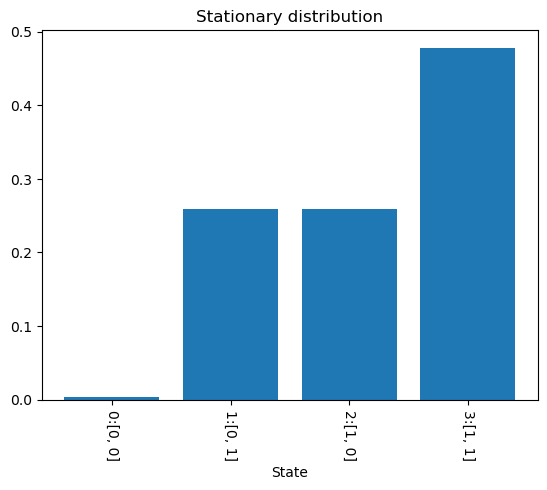

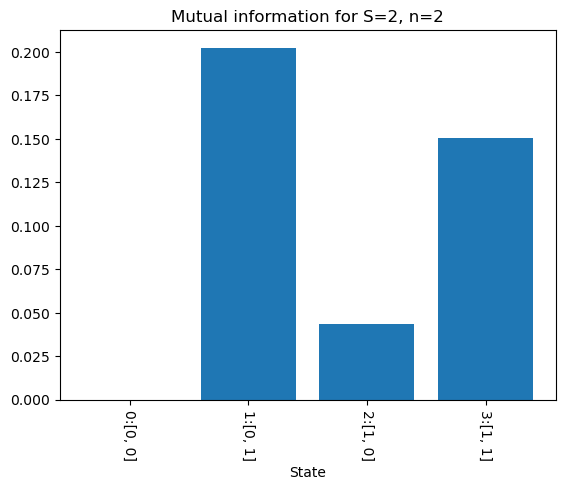

The mutual information for S=2, n=2:
tensor([-1.2517e-06,  2.0246e-01,  4.3569e-02,  1.5059e-01])


In [48]:
S, L, n_language, alpha, n_sample = 2, 100, 3, 0.5, 1
n = n_language - 1
num_test = 5000
power = 2

pi = NGramDataset(S, L, n_language, alpha, n_sample).pi
mu, _ = get_stationary(pi, S, n, output=True, max_iter=1000)
print(f'The kernel is:\n{pi}')
print(f'[p_01 p_10 p_21 p_30]:\n{[pi[0, 1].item(), pi[1, 0].item(), pi[2, 1].item(), pi[3, 0].item()]}')
print(f'The stationary distribution for S={S}, n={n}:\n{mu}')

# histogram the stationary distribution
plot_hist(mu, S, n)


# get the chi-square mutual information
mu_prod_pi = (mu.reshape(-1, 1) * pi).transpose(0, 1).view(
    tuple([S for _ in range(n+1)])
    )
MI = torch.zeros(2**n)
for i, support in enumerate(range(0, 2**n)):
    MI[i] = chi_square_mutual_info_support(support, mu_prod_pi, power)

# plot the mutual information
plot_hist(MI, 2, n, title=f'Mutual information for S={S}, n={n}')
print(f'The mutual information for S={S}, n={n}:\n{MI}')

In [32]:
print(mu[4] * pi[4, 1])
print(mu[2] * pi[2, 1])
print(mu[3] * pi[3, 0])
print(mu[5] * pi[5, 0])

tensor([0.0589])
tensor([0.0435])
tensor([0.0148])
tensor([0.0876])
